# Get vertices positions

In [ ]:
import json
import maya.OpenMaya as om
    

def get_vertex_positions_and_normals(mesh_name: str) -> list[dict]:
	# select object
    selection_list = om.MSelectionList()
    selection_list.add(mesh_name)
    dag_path = om.MDagPath()
    selection_list.getDagPath(0, dag_path)

    mesh_fn = om.MFnMesh(dag_path)

    # get positions
    vertex_positions = om.MPointArray()
    mesh_fn.getPoints(vertex_positions, om.MSpace.kObject)

    # get normals
    vertex_normals = om.MFloatVectorArray()
    mesh_fn.getVertexNormals(False, vertex_normals)

    data = []
    for i in range(vertex_positions.length()):
        position = vertex_positions[i]
        normal = vertex_normals[i]
        
        data.append(
            {
                "vtx_id": i,
                "position": (position.x, position.y, position.z),
                "normal": (normal.x, normal.y, normal.z)
            }
		)

    return data


with open(r"C:\Users\giand\OneDrive\Documents\__packages__\_perso\gt_denoiser\03_path_tracing\work\sample.json", "w") as outfile:
    json.dump(get_vertex_positions_and_normals("plane2"), outfile, indent=4)


In [6]:
import pandas as pd


df = pd.read_json("sample.json")
df.head()

,vtx_id,position,normal
0,0,"[-10.351463317871094, 0.0, 10.351463317871094]","[0.0, 1.0, 0.0]"
1,1,"[-8.281170845031738, 0.0, 10.351463317871094]","[0.0, 1.0, 0.0]"
2,2,"[-6.210878372192383, 0.0, 10.351463317871094]","[0.0, 1.0, 0.0]"
3,3,"[-4.140584945678711, 0.0, 10.351463317871094]","[0.0, 1.0, 0.0]"
4,4,"[-2.070292472839355, 0.0, 10.351463317871094]","[0.0, 1.0, 0.0]"


In [40]:
import numpy as np

def random_angle():
    return np.random.uniform(0, 2 * np.pi)

def random_distance():
    return np.random.uniform(0, 1)

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

def cross_product(v1, v2):
    return np.cross(v1, v2)

# Constants
PI = np.pi

# Random angle and distance
r1 = 2 * PI * random_angle()  # random angle around
r2 = random_distance()        # random distance from center
r2s = np.sqrt(r2)             # square root of distance from center

# Set first axis equal to normal
w = np.array([0, 0, 1])  # Assuming `w` is the z-axis (0,0,1)
u = np.array([0, 1, 0]) if np.abs(w[0]) > 0.1 else np.array([1, 0, 0])
u = normalize(cross_product(u, w))  # Second axis
v = cross_product(w, u)            # Final axis

# Random direction
psi = normalize(u * np.cos(r1) * r2s + 
                v * np.sin(r1) * r2s + 
                w * np.sqrt(1 - r2))

print(psi)


[ 0.56235277 -0.40107162  0.72311888]


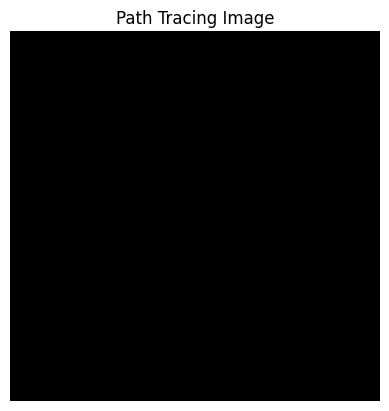

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Charger les données dans un DataFrame
data = {
    'vtx_id': [0, 1, 2, 3, 4],
    'position': [
        [-10.351463317871094, 0.0, 10.351463317871094],
        [-8.281170845031738, 0.0, 10.351463317871094],
        [-6.210878372192383, 0.0, 10.351463317871094],
        [-4.140584945678711, 0.0, 10.351463317871094],
        [-2.070292472839355, 0.0, 10.351463317871094]
    ],
    'normal': [
        [0.0, 1.0, 0.0],
        [0.0, 1.0, 0.0],
        [0.0, 1.0, 0.0],
        [0.0, 1.0, 0.0],
        [0.0, 1.0, 0.0]
    ]
}
df = pd.DataFrame(data)

# Convertir les colonnes en arrays numpy
positions = np.array(df['position'].tolist())
normals = np.array(df['normal'].tolist())

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

def dot(v1, v2):
    return np.dot(v1, v2)

def render_ray(origin, direction):
    color = np.zeros(3)
    
    # Vérifiez les intersections simples avec les surfaces
    for pos, norm in zip(positions, normals):
        norm = np.array(norm)
        pos = np.array(pos)
        ray_dir = normalize(direction)
        ray_orig = np.array(origin)
        
        # Vérifier si le rayon est perpendiculaire à la surface
        denom = dot(ray_dir, norm)
        if np.abs(denom) > 1e-6:
            t = dot(pos - ray_orig, norm) / denom
            if t > 0:
                # Trouver le point d'intersection
                intersection = ray_orig + t * ray_dir
                color += np.array([1.0, 0.0, 0.0])  # Colorer en rouge pour chaque intersection
    
    return color

def path_tracing(num_samples, max_depth):
    image_size = (512, 512)
    image = np.zeros((image_size[1], image_size[0], 3))  # Initialize image with black

    for y in range(image_size[1]):
        for x in range(image_size[0]):
            color = np.zeros(3)
            
            for _ in range(num_samples):
                # Camera parameters
                camera_x = (x / image_size[0]) * 20 - 10  # X position
                camera_y = (y / image_size[1]) * 20 - 10  # Y position
                ray_origin = np.array([camera_x, camera_y, -10])  # Position de la caméra
                ray_direction = np.array([0, 0, 1])  # Direction vers l'avant
                
                # Render the ray
                ray_color = render_ray(ray_origin, ray_direction)
                if np.any(ray_color > 0):
                    print(f"Ray Origin: {ray_origin}, Direction: {ray_direction}, Color: {ray_color}")
                color += ray_color

            color /= num_samples  # Average the color
            image[y, x] = color  # Set the pixel color

    return image

# Exemple d'utilisation du mote
num_samples = 10
max_depth = 1
image = path_tracing(num_samples, max_depth)

# Affichage de l'image
plt.imshow(image)
plt.title('Path Tracing Image')
plt.axis('off')
plt.show()
